In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch.nn.functional as F

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer

Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [14]:
class SCSELayer(nn.Module):
    def __init__(self, in_channels, out_channels, ratio, strategy):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        out_channels_reduced = out_channels // ratio
        self.fc1 = nn.Linear(out_channels, out_channels_reduced, bias=True)
        self.fc2 = nn.Linear(out_channels_reduced, out_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        if (strategy not in ['Max-Out', 'Addition', 'Multiplication', 'Concatenation']):
            raise ValueError("Invalid Concurrency Strategy")
        self.strategy = strategy
        
        self.conv1 = nn.Conv3d(in_channels=in_channels, out_channels=1, 
                          kernel_size=1, bias=False)
        
    def forward(self, x):
        batch_size, num_channels, _, _, _ = x.size()
        # Average along each channel
        squeeze_tensor = self.avg_pool(x)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor.view(batch_size, num_channels)))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))
        
        #Spatial squeeze
        spatial_squeeze = self.conv1(x)
        spatial_se_out = self.sigmoid(spatial_squeeze)

        output_tensor_se = torch.mul(x, fc_out_2.view(batch_size, num_channels, 1, 1, 1))
        
        output_tensor_spatial_se = torch.mul(x, spatial_se_out)
        
        if (strategy == 'Max-Out'):
            output_tensor = torch.max(output_tensor_se, output_tensor_spatial_se)
        elif (strategy == 'Addition'):
            output_tensor = output_tensor_se + output_tensor_spatial_se
        elif (strategy == 'Multiplication'):
            output_tensor = torch.mul(output_tensor_se, output_tensor_spatial_se)
        else:
            output_tensor = torch.cat((output_tensor_se, output_tensor_spatial_se), 1)

        return output_tensor

In [15]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [16]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.se_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        ratio = 2
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.se_layers.append(SELayer(out_channels, ratio))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, mish, batch, se, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.se_layers, self.dropout_layers):
            x = conv(x)
            x = batch(x)
            x = mish(x)
            x = se(x)
            x = drop(x)
            
        return x

In [17]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.se_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        ratio = 2
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.se_layers.append(SELayer(out_channels, ratio))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        ratio=2
        for conv, mish, batch, se, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.se_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = mish(x)
            x = se(x)
            x = drop(x)
            
        out = self.conv_final(x)
        return out

In [18]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [19]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [20]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = RMSELoss()
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

Training the model

In [21]:
model_path = os.path.join('../../../models/STConvS2S_SE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, patience=5)


In [ ]:
train_losses, val_losses = trainer.train_evaluate()

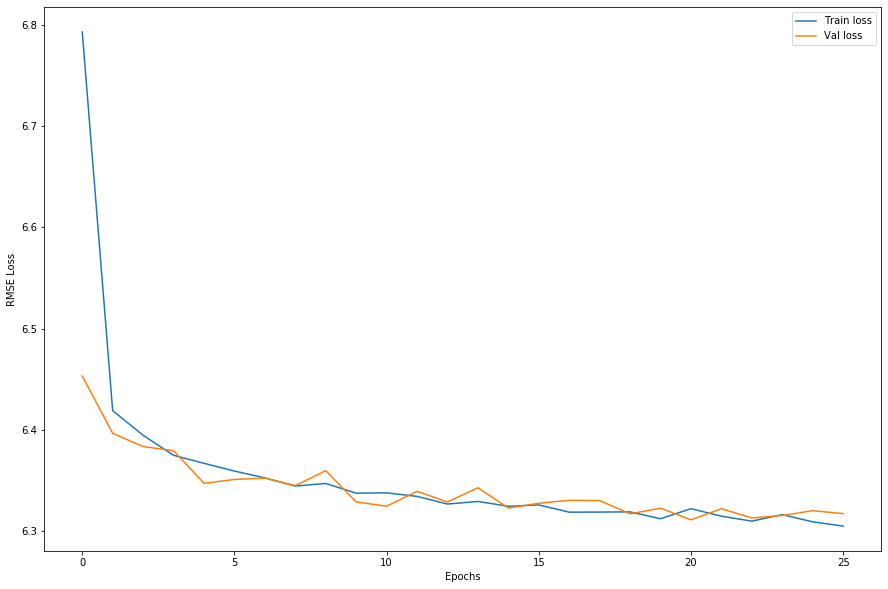

In [24]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [22]:
trainer.path = '../../../models/CHIRPS/5_step/STConvS2S_SE_m04d08-h14m04s13.pth.tar'

model, optimizer, epoch, loss = trainer.load_model()
iter_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        iter_test_loss += loss.detach().item()
test_loss = iter_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.2942


In [23]:
trainer.path = '../../../models/CHIRPS/5_step/STConvS2S_SE_m04d08-h14m04s13.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        for j in range(2,5):
            previous_three_steps.append(x[0,0,j,:,:])
        x,y = x.to(device), y.to(device)
        ground_truth = y[0,0,:,:]
        output = model(x)
        prediction = output[0,0,:,:]
        print(criterion(prediction, ground_truth))
        break


tensor(4.2507, device='cuda:0')


In [29]:
print(prediction.size())

torch.Size([5, 50, 50])


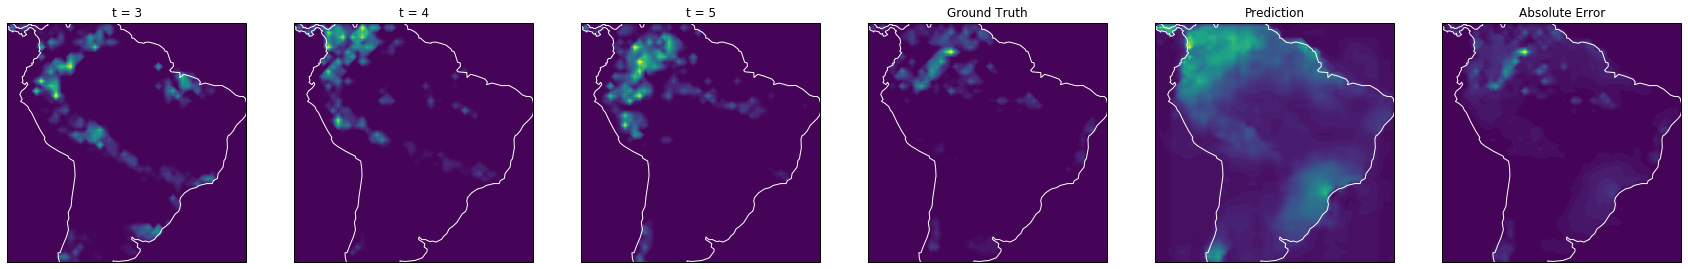

In [33]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
plt.figure(figsize=(30, 10))
sst = previous_three_steps[0]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 6, 1, projection=ccrs.PlateCarree())
cs = plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax1.coastlines(color='white')
plt.title('t = 3')

sst = previous_three_steps[1]
ax2 = plt.subplot(1, 6, 2, projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax2.coastlines(color='white')
plt.title('t = 4')

sst = previous_three_steps[2]
ax3 = plt.subplot(1, 6, 3, projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax3.coastlines(color='white')
plt.title('t = 5')

sst = ground_truth[0,:,:].cpu()
ax4 = plt.subplot(1, 6, 4, projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax4.coastlines(color='white')
plt.title('Ground Truth')

sst = prediction[0,:,:].cpu()
ax5 = plt.subplot(1, 6, 5, projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax5.coastlines(color='white')
plt.title('Prediction')

sst = abs(ground_truth[0,:,:]-prediction[0,:,:]).cpu()
ax6 = plt.subplot(1, 6, 6, projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax6.coastlines(color='white')
plt.title('Absolute Error')
plt.show()